<a href="https://colab.research.google.com/github/KhaldounN/DSF_FINAL/blob/main/Full_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install plotly==4.5.2

In [ ]:
!pip3 install flair

In [ ]:

!python -m spacy download en_core_web_md

# Train Model to classify Emotions

                                               Input Sentiment
0                            i didnt feel humiliated   sadness
1  i can go from feeling so hopeless to so damned...   sadness
2   im grabbing a minute to post i feel greedy wrong     anger
3  i am ever feeling nostalgic about the fireplac...      love
4                               i am feeling grouchy     anger


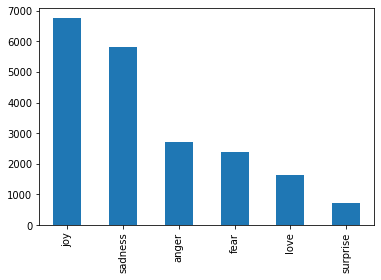

In [6]:
# Import data

import pandas as pd 
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('/content/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('/content/test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val = pd.read_csv('/content/val.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')

#join data to split later on 
df = pd.concat([df_train,df_test, df_val])


#check data balance 
print(df.head())
df['Sentiment'].value_counts().plot(kind = 'bar')

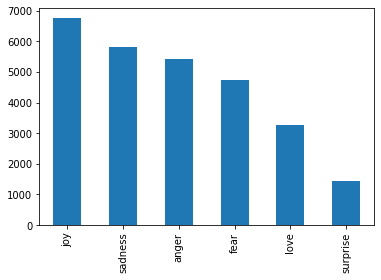

In [7]:
#douplicate the  imbalanced labels to balance data

df2 = df[df.Sentiment.isin(['fear','anger','love','surprise'])]
df = pd.concat([df,df2])
df['Sentiment'].value_counts().plot(kind = 'bar')

In [8]:
# Prepare Victorizer 

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english', ngram_range=(1,1), tokenizer = token.tokenize)

# fit Victorizer 
X = cv.fit_transform(df['Input'])


In [9]:
#split data set 
from sklearn.model_selection import train_test_split

y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, random_state=20)

In [10]:
#intial and fit the ML model
from sklearn.ensemble import RandomForestClassifier
model_emotions = RandomForestClassifier()
model_emotions.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
# Test Model and print Accuracy 
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,classification_report

predicted = model_emotions.predict(X_test)
acc_score = metrics.accuracy_score(predicted,y_test)
prec_score = precision_score(y_test,predicted, average='macro')
recall = recall_score(y_test, predicted,average='macro')
f1 = f1_score(y_test,predicted,average='macro')
matrix = confusion_matrix(y_test,predicted)


print(str('Accuracy: '+'{:04.2f}'.format(acc_score*100))+'%')
print(str('Precision: '+'{:04.2f}'.format(prec_score*100))+'%')
print(str('Recall: '+'{:04.2f}'.format(recall*100))+'%')
print('F1 Score: ',f1)
print(matrix)


Accuracy: 93.32%
Precision: 92.49%
Recall: 94.03%
F1 Score:  0.931288517561098
[[769   2   2   2   3   0]
 [ 11 705   0   0   4   6]
 [ 12  10 913  55  30   9]
 [  0   0  11 451   0   0]
 [ 37  24  25  13 810   5]
 [  0  12   0   2   0 194]]


### manual check on Model 

In [16]:
### Manual test of the model 

text  = ['this makes me happy' , ' this is a  let down ', ' I am sad ', ' I am pissed off' , 'I liked him alot', ' it disgust me']
result =model_emotions.predict(cv.transform(text))

results = pd.DataFrame(text,result)
results

,0
joy,this makes me happy
anger,this is a let down
sadness,I am sad
anger,I am pissed off
love,I liked him alot
anger,it disgust me


In [17]:
# Save the model and victorizer using pickle 
import pickle
filename = 'emotions_detector.sav'
pickle.dump(model_emotions, open(filename, 'wb'))
pickle.dump(cv, open("vectorizer.pickle", "wb"))

# Importing needed libraries 


In [29]:
from flair.models import TextClassifier
from flair.data import Sentence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
import spacy
import pickle
from nltk.tokenize import RegexpTokenizer
import warnings; 
warnings.simplefilter('ignore')

# Defining Functions 

In [22]:

# load book , clean data and split into sentences 

def Load_book(path):
  book = open(path, 'r').read()
  book = book.replace("_",' ')
  book = book.replace("\n",'')
  sentences  = book.split('.')

  return sentences 





# run sentiment analysis on each sentence in the book and save results into df_setiment 
def Analyzse_sentiment(sentences):
  """initial dataset to be used for saving results """
  df_sentiment = pd.DataFrame((np.zeros((4,int(len(sentences)))))) 


  """initial flair model"""
  tagger = TextClassifier.load('sentiment')

  """predict sentiment per sentence and save results in dataframe"""
  for i, sentence in enumerate(sentences):
    if sentence != "": 
      sentence = Sentence(sentence)
      tagger.predict(sentence)
      df_sentiment[i].update(sentence.labels)



  """make results more readable (make negative sentiment negative numbers..etc) """
  for i , sentence in enumerate(df_sentiment.iloc[0,:]):
      try:
        df_sentiment.iloc[1,i] = sentence.value
        if sentence.value == 'NEGATIVE':
          df_sentiment.iloc[2,i] = sentence.score * (-1)
        else:
          df_sentiment.iloc[2,i] = sentence.score
      except:
        pass

  return df_sentiment




# calcualte Major and Minor sentiment and vizualize it in a dashabord style

def Display_sentiment(df_sentiment  , booktitle = ' book title'):


  """ calcualte display data """
  l = df_sentiment.iloc[2,:]
  l = pd.DataFrame(l) 
  l['Major'] = l.iloc[:,0].rolling(40).mean()
  l['Minor'] = l.iloc[:,0].rolling(10).mean()
  
  
  
  
  """Plot"""
  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30, 15))
  axes[0].set_title((str(booktitle) + ' : Sentimental Tendency') , fontsize = 30  , loc='left')
  axes[0].plot(l['Major'])
  axes[0].set_xlabel('Sentences' , fontsize=20)
  axes[0].set_ylabel('Sentiment', fontsize=20)
  axes[0].legend(['Major Sentiment(rolling average for 30 sentences)'], fontsize=20)
  axes[0].fill_between(l.index, l['Major'] ,0 , where=l['Major'] >= 0, facecolor='lightgreen',  interpolate=True)
  axes[0].fill_between(l.index, l['Major'] ,0 , where=l['Major'] <= 0, facecolor='lightcoral',  interpolate=True)
  axes[0].set_facecolor('white')
  axes[1].plot(l['Minor'])
  axes[1].set_xlabel('Sentences' , fontsize=15)
  axes[1].set_ylabel('Sentiment' , fontsize=15)
  axes[1].fill_between(l.index, l['Minor'] ,0 , where=l['Minor'] >= 0, facecolor='lightgreen',  interpolate=True)
  axes[1].fill_between(l.index, l['Minor'] ,0 , where=l['Minor'] <= 0, facecolor='lightcoral',  interpolate=True)
  axes[1].set_facecolor('white')
  axes[1].legend(['Minor Sentiment(rolling average for 5 sentences)'] , fontsize=20)




# run emotions dedection on each sentence 
def Analyzse_Emotions(sentences):
  
  """ initiate Tokanizer"""
  token = RegexpTokenizer(r'[a-zA-Z0-9]+')
  
  
  
  """ Load Model and Victorizer"""
  cv = pickle.load(open("vectorizer.pickle", 'rb'))
  df_emotions = pd.DataFrame((np.zeros((1,int(len(sentences))))))
  filename = 'emotions_detector.sav'
  model = pickle.load(open(filename, 'rb'))
  
  
  
  """ Iterate Over each sentence and predict Emoitn then save results in a data frame"""
  for i , sentence in enumerate( sentences):
    try:
        result = model.predict(cv.transform([sentence]))
        df_emotions[i].update(result)
    except:
      pass
  return df_emotions


# perform calculations on df_emotions and display results 
def Display_emotions(df_emotions , booktitle = 'Book Title'):

  """ caulcate axies and prepare data for radar plot"""
  l = df_emotions.T.value_counts().index
  l = l.tolist()
  v = df_emotions.T.value_counts()
  v = v.tolist()

  """ plot radar"""
  fig = go.Figure(data=go.Scatterpolar(r=v,theta=l,fill='toself'))
  fig.update_layout(polar=dict(radialaxis=dict(visible=False),),showlegend=False ,   title={
        'text': (str(booktitle)+' : Composition of Emotion ')})
  fig.show()



  """ calcualte data for line chart """
  df_emotions1 = df_emotions.T
  df_emotions1['Sentences(50)'] =  ((df_emotions1.index/50).astype(int))*50
  df_emotions1['1'] = df_emotions1.index
  data = df_emotions1.groupby(by=['Sentences(50)',0]).count()
  data = pd.DataFrame(data)
  data.reset_index(inplace=True)  
  data.columns = ['Sentences','Emotion','Count']
  
  
  
  """ plot"""
  fig = px.line(data,
                 x=	'Sentences' ,  y='Count', color='Emotion',
                 title=((str(booktitle)+" : Emotional Journey")))
  fig.show()



# The Below Function retrive a Data Frame containing all the Entities detected and entity label ( index is sentence in text)
def Analyze_entities(sentences):


  """ initiate two datasets to be used for saving results """
  df_ent = pd.DataFrame((np.zeros((100,int(len(sentences))))))
  df_ents = pd.DataFrame((np.zeros((3,int(len(sentences))))))
  l = []


  """Load sapcy Model """
  nlp_md = spacy.load('en_core_web_md')

  """ transfor data into doc.ents df """
  for i , sentence in enumerate(sentences):
    doc = nlp_md(sentence)
    df_ent[i].update(doc.ents)



    """ save attriiputes of each entity into dataframe while keeping index of sentence"""
  for  j , raw in df_ent.iteritems():
    for i , item in enumerate(raw):
      item2 = item
      if str(item2) != '0.0':
        l = [j , item.text , item.label_]
        df_ents[j].update(l)
  """ tranform data frame into desired form """
  df_ents = df_ents.T

  """ remove empty reconds"""
  df_ents = df_ents[df_ents[1] != 0]

  """rename columns"""
  df_ents.columns = ['Count','entity','label']

  """ filter to desired entity types"""
  df_ents = df_ents[df_ents.label.isin([ 'PERSON' ,'NORP','GPE', 'LOC','EVENT', 'LAW'])]
  
  return df_ents
  






#the Below Function draw a Sunburt chart displaying entities mentioned alog with their types 

def Display_entities(df_ents , booktitle = 'Booktitle'):

  """ replace label with more clear labels """
  df_ents = df_ents.replace('NORP', 'Nationalities/groups')
  df_ents = df_ents.replace('PERSON', 'People')
  df_ents = df_ents.replace('GPE', 'Countries/Cities')
  df_ents = df_ents.replace('LOC', 'Locations')
  df_ents = df_ents.replace('EVENT', 'Event')
  df_ents = df_ents.replace('LAW', 'Laws')


  """ prepare data for sunburst figure"""
  df_ents1 = df_ents
  df_ents1 = df_ents1.groupby(by=['label','entity']).count().sort_values(by='Count', ascending=False).head(20)
  df_ents1 = df_ents1.reset_index(level=['label', 'entity'])

  """ plot """
  fig = px.sunburst(df_ents1, path=['label', 'entity'], values='Count' , title=( str(booktitle)+" : Mentions of Entities (locations, nationalities, events, and characters)"))
  fig.update_layout(width=1500,height=900)
  fig.show()

  """prepare data for line chart plot """
  df_ents2 = df_ents
  df_ents2['sentence'] = ((df_ents2.index/50).astype(int))*50
  df_ents2 = df_ents2.groupby(by=['sentence','label','entity']).count()
  df_ents2 = df_ents2.reset_index(level=['sentence','label','entity'])
  df_ents2 = df_ents2[df_ents2['Count'] > 1]
  df_ents2.columns = ['sentence(every 50 senteces)', 'label', 'entity', 'count']


  """ plot"""
  fig = px.scatter(df_ents2,x='sentence(every 50 senteces)', y="entity",
	         size="count", color="entity")
  fig.show()



# main function that fun all analysis and dispaly all results 
def Analyze_Book(path,booktitle="Book Title"):
  warnings.filterwarnings("always")
  sentences = Load_book(path)
  df_sent = Analyzse_sentiment(sentences)
  df_emo = Analyzse_Emotions(sentences)
  df_ent = Analyze_entities(sentences)
  Display_sentiment(df_sent , booktitle)
  Display_entities(df_ent , booktitle)
  Display_emotions(df_emo , booktitle )


2020-12-17 21:03:56,747 loading file /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/content/Beyond good and Evil.txt' mode='r' encoding='UTF-8'>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: ResourceWarning:

unclosed file <_io.BufferedReader name='vectorizer.pickle'>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: ResourceWarning:

unclosed file <_io.BufferedReader name='emotions_detector.sav'>

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:3062: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:3062: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.6/dist-packages/pandas/core/ser

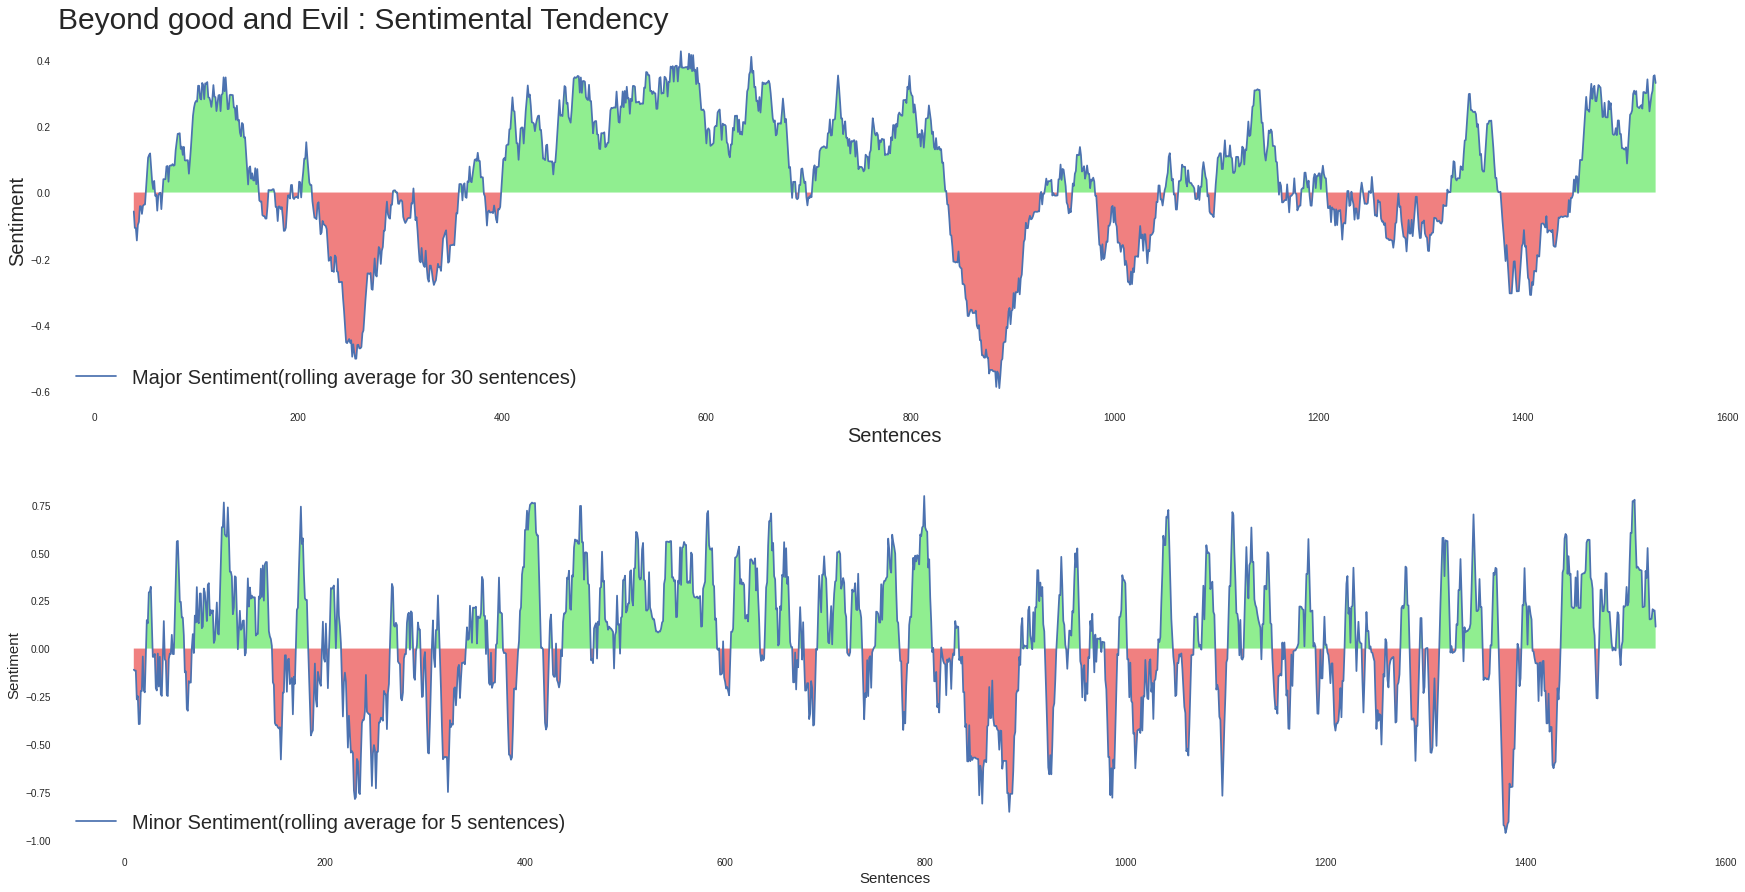

In [36]:
Analyze_Book('/content/Beyond good and Evil.txt' , 'Beyond good and Evil')